# Phase 2: Vessel Segmentation (Both Volumes)

Clean, systematic vessel segmentation using OCTA-autosegmentation for both volumes.

## Workflow:
1. Load MIPs from Phase 1
2. Prepare both images for OCTA-autosegmentation
3. Run segmentation on both volumes
4. Extract skeletons and bifurcations
5. Save all outputs for Phase 3

## Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import cv2
import subprocess
from skimage.morphology import skeletonize
from scipy import ndimage

# Setup paths
data_dir = Path('data')
octa_seg_repo = Path('/home/aristarx/Diploma/OCTA-autosegmentation')

print("✓ Imports complete")

✓ Imports complete


## Step 1: Load MIPs from Phase 1

Loaded MIPs:
  Volume 0: (1536, 360)
  Volume 1: (1536, 360)


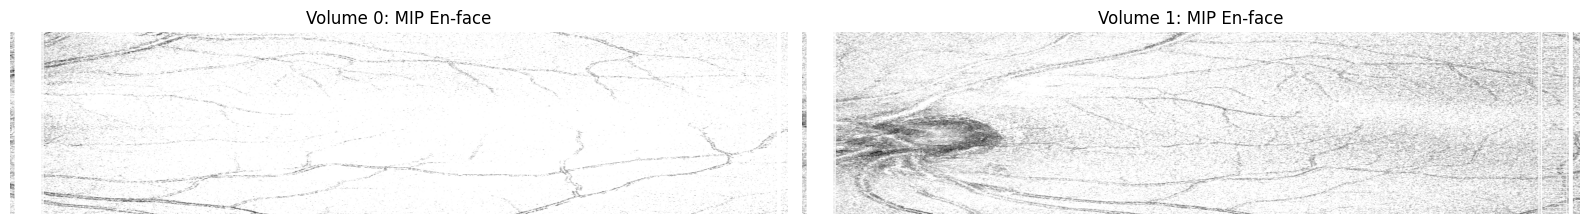

In [2]:
# Load both MIPs
mip_v0 = np.load(data_dir / 'enface_mip_volume0.npy')
mip_v1 = np.load(data_dir / 'enface_mip_volume1.npy')

print(f"Loaded MIPs:")
print(f"  Volume 0: {mip_v0.shape}")
print(f"  Volume 1: {mip_v1.shape}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].imshow(mip_v0.T, cmap='gray', origin='lower')
axes[0].set_title('Volume 0: MIP En-face')
axes[0].axis('off')

axes[1].imshow(mip_v1.T, cmap='gray', origin='lower')
axes[1].set_title('Volume 1: MIP En-face')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## Step 2: Prepare Images for Segmentation

Prepared images: (304, 304)


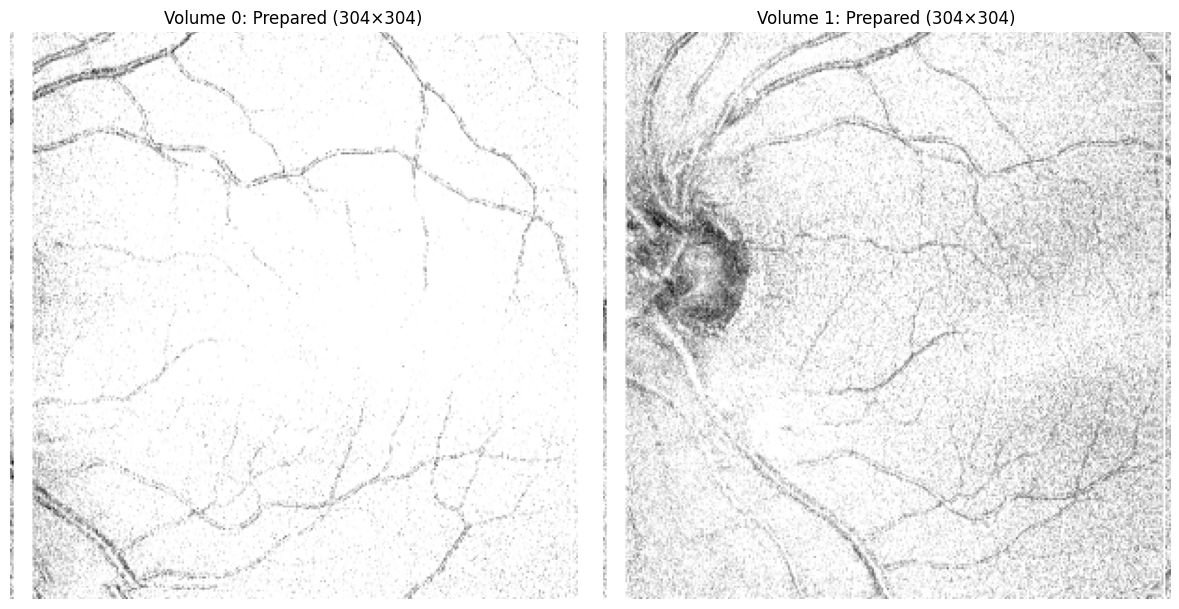

In [3]:
def prepare_for_segmentation(mip, target_size=(304, 304)):
    """Normalize and resize MIP for OCTA-autosegmentation."""
    # Normalize to 0-255
    img_norm = ((mip - mip.min()) / (mip.max() - mip.min()) * 255).astype(np.uint8)
    # Transpose to (Z, W) for standard orientation
    img_norm = img_norm.T
    # Resize to model input size
    img_resized = cv2.resize(img_norm, target_size, interpolation=cv2.INTER_LINEAR)
    return img_resized

# Prepare both images
img_v0 = prepare_for_segmentation(mip_v0)
img_v1 = prepare_for_segmentation(mip_v1)

print(f"Prepared images: {img_v0.shape}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img_v0, cmap='gray')
axes[0].set_title('Volume 0: Prepared (304×304)')
axes[0].axis('off')

axes[1].imshow(img_v1, cmap='gray')
axes[1].set_title('Volume 1: Prepared (304×304)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## Step 3: Run OCTA-autosegmentation

In [4]:
# Create input/output directories
input_dir = data_dir / 'seg_input'
output_dir = data_dir / 'seg_output'
input_dir.mkdir(exist_ok=True, parents=True)
output_dir.mkdir(exist_ok=True, parents=True)

# Save both images
cv2.imwrite(str(input_dir / 'volume0.png'), img_v0)
cv2.imwrite(str(input_dir / 'volume1.png'), img_v1)
print(f"✓ Saved input images")

# Run segmentation
config_file = octa_seg_repo / 'docker/trained_models/ves_seg-S-GAN/config.yml'
abs_input = Path.cwd() / input_dir
abs_output = Path.cwd() / output_dir

cmd = [
    sys.executable,
    str(octa_seg_repo / 'test.py'),
    '--config_file', str(config_file),
    '--Test.data.image.files', f'{abs_input}/**/*.png',
    '--Test.save_dir', str(abs_output),
    '--epoch', '30',
    '--General.device', 'cpu'
]

print(f"\nRunning OCTA-autosegmentation...")
result = subprocess.run(cmd, capture_output=True, text=True, cwd=str(octa_seg_repo))

if result.returncode == 0:
    print("✓ Segmentation complete!")
else:
    print(f"✗ Failed: {result.stderr}")

✓ Saved input images

Running OCTA-autosegmentation...
✓ Segmentation complete!


## Step 4: Load Segmentation Results

Found 2 segmentation results:
  model_volume0.png
  model_volume1.png

Vessel masks:
  Volume 0: (1216, 1216), 35.86% vessel coverage
  Volume 1: (1216, 1216), 52.16% vessel coverage


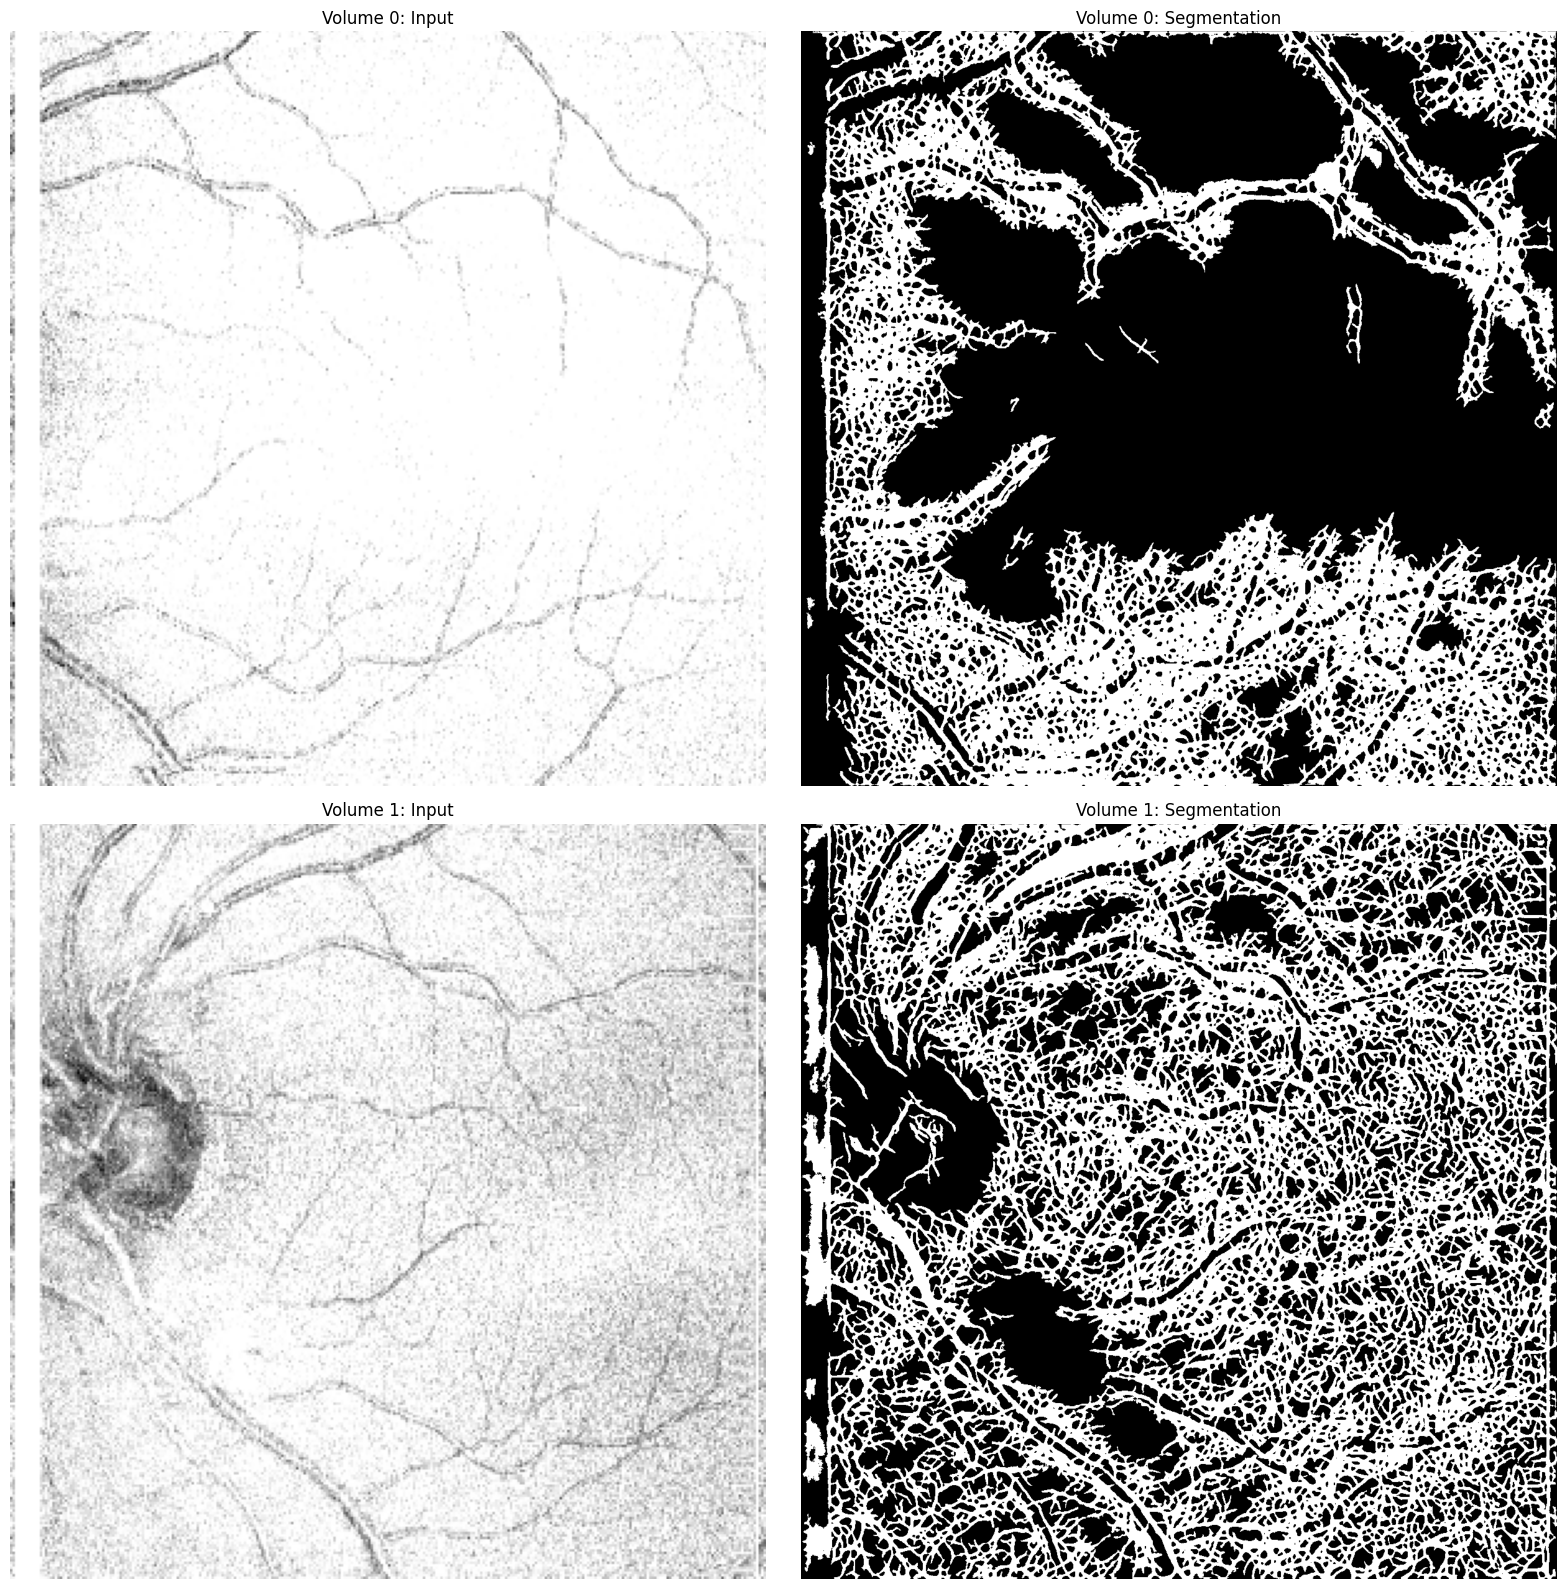

In [5]:
# Find segmentation outputs
seg_files = sorted(list(output_dir.glob('**/*.png')))
print(f"Found {len(seg_files)} segmentation results:")
for f in seg_files:
    print(f"  {f.name}")

if len(seg_files) != 2:
    raise ValueError(f"Expected 2 segmentation results, found {len(seg_files)}")

# Load and binarize
seg_v0 = cv2.imread(str(seg_files[0]), cv2.IMREAD_GRAYSCALE)
seg_v1 = cv2.imread(str(seg_files[1]), cv2.IMREAD_GRAYSCALE)

mask_v0 = seg_v0 > 127
mask_v1 = seg_v1 > 127

print(f"\nVessel masks:")
print(f"  Volume 0: {mask_v0.shape}, {100*mask_v0.sum()/mask_v0.size:.2f}% vessel coverage")
print(f"  Volume 1: {mask_v1.shape}, {100*mask_v1.sum()/mask_v1.size:.2f}% vessel coverage")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 16))

axes[0, 0].imshow(img_v0, cmap='gray')
axes[0, 0].set_title('Volume 0: Input')
axes[0, 0].axis('off')

axes[0, 1].imshow(mask_v0, cmap='gray')
axes[0, 1].set_title('Volume 0: Segmentation')
axes[0, 1].axis('off')

axes[1, 0].imshow(img_v1, cmap='gray')
axes[1, 0].set_title('Volume 1: Input')
axes[1, 0].axis('off')

axes[1, 1].imshow(mask_v1, cmap='gray')
axes[1, 1].set_title('Volume 1: Segmentation')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

## Step 5: Extract Skeletons and Bifurcations

Processing Volume 0...
  Raw: 18050 → Clustered: 3632 → Final: 2094
Processing Volume 1...
  Raw: 31388 → Clustered: 6240 → Final: 5539


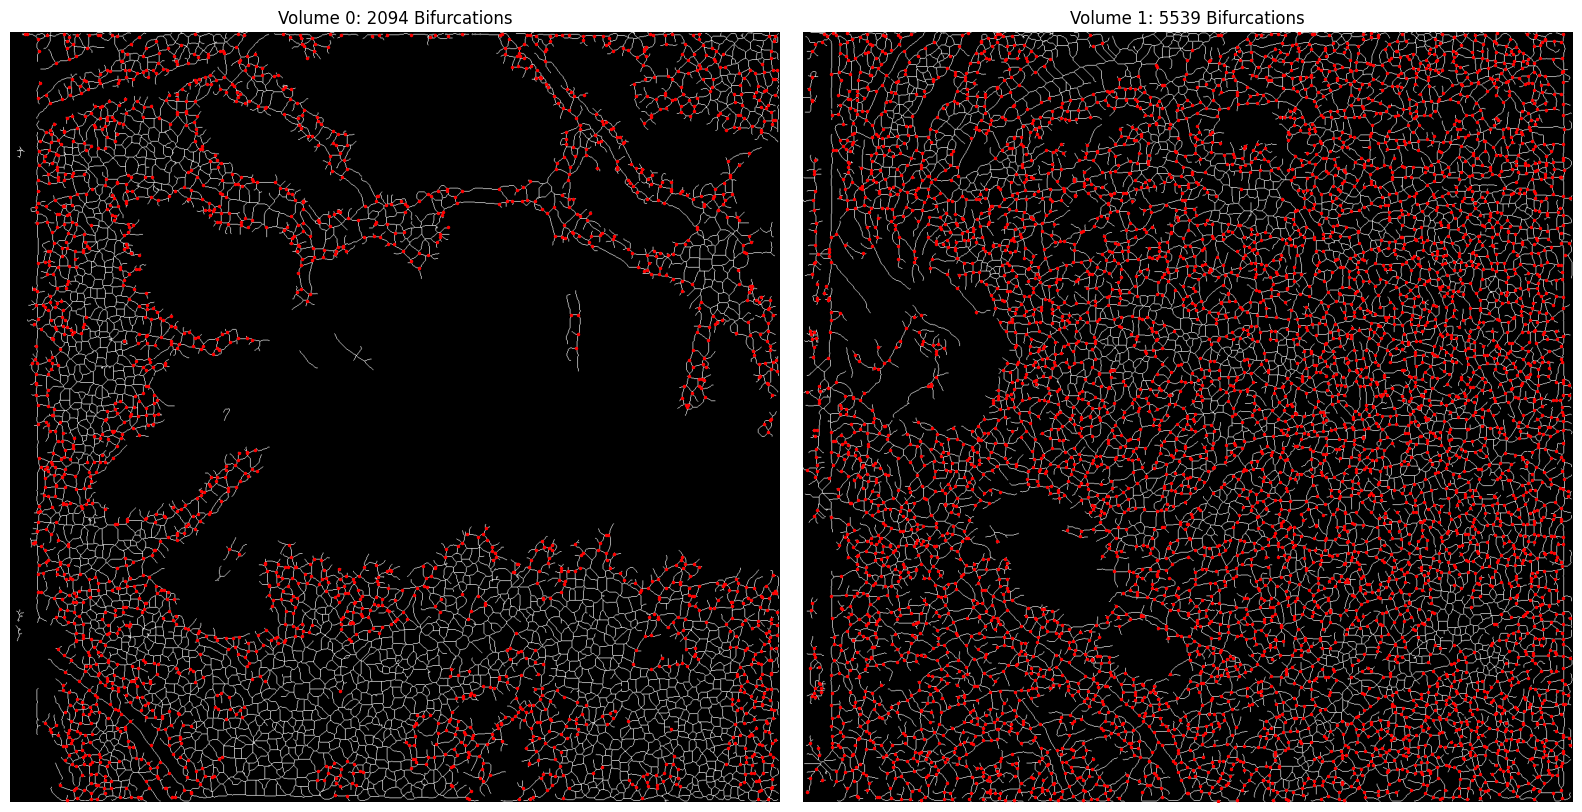

In [6]:
def extract_bifurcations(skeleton):
    """Extract bifurcation points (3+ neighbors)."""
    kernel = np.ones((3, 3), dtype=np.uint8)
    kernel[1, 1] = 0
    neighbor_count = ndimage.convolve(skeleton.astype(np.uint8), kernel, mode='constant')
    bifurcations = (neighbor_count >= 3) & skeleton
    coords = np.column_stack(np.where(bifurcations))
    return bifurcations, coords

def cluster_bifurcations(coords, min_distance=8):
    """Cluster nearby bifurcations to remove artifacts."""
    if len(coords) == 0:
        return coords
    filtered = []
    used = np.zeros(len(coords), dtype=bool)
    for i in range(len(coords)):
        if used[i]:
            continue
        y, x = coords[i]
        distances = np.sqrt((coords[:, 0] - y)**2 + (coords[:, 1] - x)**2)
        nearby = distances < min_distance
        used[nearby] = True
        centroid = coords[nearby].mean(axis=0).astype(int)
        filtered.append(centroid)
    return np.array(filtered)

def filter_by_quality(coords, vessel_mask, density_range=(0.15, 0.7), window_size=50):
    """Filter bifurcations by local vessel density."""
    vessel_density = ndimage.uniform_filter(vessel_mask.astype(float), size=window_size)
    quality_mask = (vessel_density > density_range[0]) & (vessel_density < density_range[1])
    filtered = []
    for y, x in coords:
        if quality_mask[y, x]:
            filtered.append([y, x])
    return np.array(filtered) if filtered else np.array([]).reshape(0, 2)

# Process Volume 0
print("Processing Volume 0...")
skel_v0 = skeletonize(mask_v0)
_, bif_raw_v0 = extract_bifurcations(skel_v0)
bif_clust_v0 = cluster_bifurcations(bif_raw_v0)
bif_v0 = filter_by_quality(bif_clust_v0, mask_v0)
print(f"  Raw: {len(bif_raw_v0)} → Clustered: {len(bif_clust_v0)} → Final: {len(bif_v0)}")

# Process Volume 1
print("Processing Volume 1...")
skel_v1 = skeletonize(mask_v1)
_, bif_raw_v1 = extract_bifurcations(skel_v1)
bif_clust_v1 = cluster_bifurcations(bif_raw_v1)
bif_v1 = filter_by_quality(bif_clust_v1, mask_v1)
print(f"  Raw: {len(bif_raw_v1)} → Clustered: {len(bif_clust_v1)} → Final: {len(bif_v1)}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].imshow(skel_v0, cmap='gray')
axes[0].plot(bif_v0[:, 1], bif_v0[:, 0], 'r.', markersize=3)
axes[0].set_title(f'Volume 0: {len(bif_v0)} Bifurcations')
axes[0].axis('off')

axes[1].imshow(skel_v1, cmap='gray')
axes[1].plot(bif_v1[:, 1], bif_v1[:, 0], 'r.', markersize=3)
axes[1].set_title(f'Volume 1: {len(bif_v1)} Bifurcations')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## Step 6: Save Results for Phase 3

In [7]:
# Save all results
np.save(data_dir / 'vessel_mask_volume0.npy', mask_v0)
np.save(data_dir / 'vessel_skeleton_volume0.npy', skel_v0)
np.save(data_dir / 'bifurcation_coords_volume0.npy', bif_v0)

np.save(data_dir / 'vessel_mask_volume1.npy', mask_v1)
np.save(data_dir / 'vessel_skeleton_volume1.npy', skel_v1)
np.save(data_dir / 'bifurcation_coords_volume1.npy', bif_v1)

print("✓ Saved all results:")
print(f"  Volume 0: {len(bif_v0)} bifurcations")
print(f"  Volume 1: {len(bif_v1)} bifurcations")
print(f"\n✓ Phase 2 complete! Ready for Phase 3 (XY registration).")

✓ Saved all results:
  Volume 0: 2094 bifurcations
  Volume 1: 5539 bifurcations

✓ Phase 2 complete! Ready for Phase 3 (XY registration).
